# Comparison of cwt convolution performances

Starting from PR490(version > 1.0.3 ?), pywt.cwt() can use two methods to compute the convolution product of the wavelet support and the signal being analysed. 
- The `conv` method is based on `numpyp.conv` which uses a sliding window product which complexity is $\mathcal{O}(s*n)$ where _s_ is the *scale* of the wavelet and *n* is the number of samples in the signal
- the `fft` method is based on the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) and has a complexity of $\mathcal{O}((s+n)*log(s+n))$

In practice, the domains where each algorithm is the most efficient is non trivial. Hence this benchmark provides quick visual hints to assess this information. As a rule of thumb, the `fft` method will become highly efficient when scales and signal become large and computing times goes over a few seconds.

There are two flavors of `fft` based methods which are tested here
- the first one relies on scipy method `next_fast_len` which select an optimal padding size for  the fft.
- the second ones uses a fallback method using the next power of two as the padding size. This has to be considered only when `scipy` is not installe on the system

In [1]:
import pywt  # needs devel version with cwt(method='fft') support
import numpy as np
import scipy.fftpack # ensure scipy is available
import time
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.rcParams.update({
        'legend.fontsize': 'large',
        'figure.figsize': (8,5),
        'axes.labelsize': 'large',
        'axes.titlesize':'large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
    )

In [4]:
try:
    import cpuinfo
    processor = cpuinfo.get_cpu_info()['brand']
except ImportError:
    import platform
    processor = platform.processor()
print(f"Processor type used for the benchmark: {processor}")

Processor type used for the benchmark: Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz


In [2]:
# defaults    
signal_sizes = np.logspace(1, 6, 10).astype(np.int)
wavelet      = 'cmorl1-1'
nrun         = 7

def bench_sizes(sizes, scales, wavelet, method, nrun=1, agg=np.median):
    all_run = []
    for i in range(nrun):
        run = []
        for size in sizes:
            signal = np.zeros(size, dtype=np.float64)
            t0     = time.time()
            c, f   = pywt.cwt(signal, scales, wavelet, method=method)
            run.append(time.time() - t0)
        all_run.append(run)
    all_run = np.asarray(all_run)
    return agg(all_run, axis=0)
    

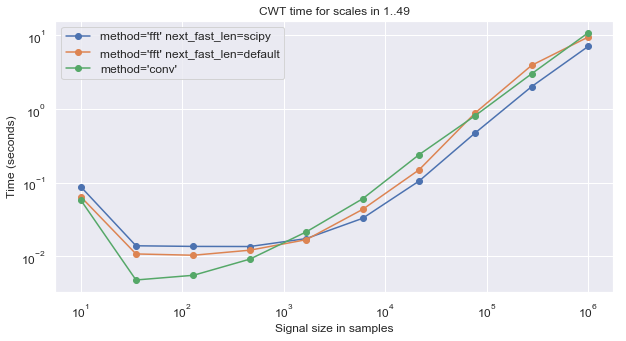

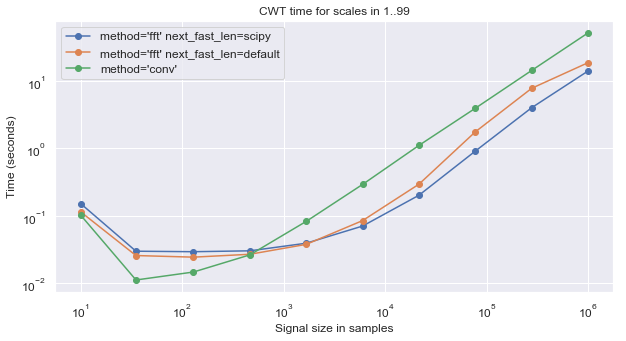

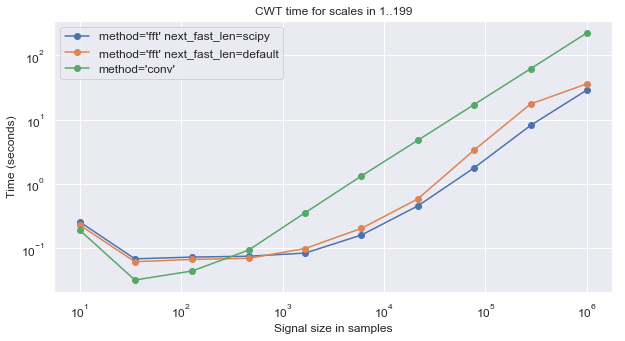

In [3]:
for scales in [ np.arange(1,50),np.arange(1,100), np.arange(1,200)]:
    # default fFT mode
    pywt._cwt.next_fast_len = scipy.fftpack.next_fast_len
    times_fft_with_scipy = bench_sizes(signal_sizes, scales, wavelet, 'fft', nrun=nrun)

    # fft mode with no scipy fallback
    pywt._cwt.next_fast_len = lambda n: 2**np.int(np.ceil(np.log2(n)))
    times_fft_with_default = bench_sizes(signal_sizes, scales, wavelet, 'fft', nrun=nrun)
    
    # conv mode
    times_conv = bench_sizes(signal_sizes, scales, wavelet, 'conv', nrun=nrun)
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(signal_sizes, times_fft_with_scipy,   'o-', label="method='fft' next_fast_len=scipy")
    plt.plot(signal_sizes, times_fft_with_default, 'o-', label="method='fft' next_fast_len=default")
    plt.plot(signal_sizes, times_conv,             'o-', label="method='conv'")
    plt.xlabel("Signal size in samples")
    plt.ylabel("Time (seconds)")
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    text = plt.title(f'CWT time for scales in 1..{max(scales)}')

Note: 
- the plots are in log-log scale and the differences are rather important
- the use of scipy notably improves the computing times as the function `next_fast_len` allow for selecting optimal buffer sizes at each scale
- the slope is 1 for `method='conv'` because on each plot the scale range is __fixed__. In this case the `conv` method complexity becomes $s*\mathcal{O}(n)$ and it will eventually outperform the `fft` method when $n$ becomes large enough.